# Excited States via SSVQE

This notebook validates that:
- SSVQE runs for `num_states=k` states
- Works under noise

It prints:
- Lowest k exact eigenvalues of a reference Hamiltonian
- SSVQE final energies for states 0, 1, ..., k-1
- |ΔE_i| versus exact eigenvalue i

In [1]:
import numpy as np
import pennylane as qml
from pennylane import qchem

from vqe.ssvqe import run_ssvqe
from vqe.visualize import plot_multi_state_convergence

## Configuration

In [2]:
molecule = "H2"

# k-state target
num_states = 4

# Ansatz/optimizer
ansatz_name = "StronglyEntanglingLayers"
optimizer_name = "Adam"
steps = 250
stepsize = 0.2
seed = 0

# SSVQE weights (None => [1,2,3,...])
weights = None

# Noise knobs (leave at 0 for noiseless section)
depolarizing_prob = 0.00
amplitude_damping_prob = 0.00

## Exact spectrum benchmark (reference Hamiltonian)

We construct a minimal reference Hamiltonian for H₂ using PennyLane's qchem helper.
This is only used to compute exact eigenvalues for comparison; SSVQE itself uses
the package API.

In [3]:
# Registry-style H2 geometry (Å). Keep this consistent with your package registry.
sym = ["H", "H"]
coords = np.array(
    [
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.7414],
    ],
    dtype=float,
)
basis = "sto-3g"

H_ref, n_wires = qchem.molecular_hamiltonian(sym, coords, basis=basis)

Hmat = np.array(qml.matrix(H_ref), dtype=float)
evals = np.sort(np.linalg.eigvalsh(Hmat))

print(f"Molecule: {molecule}")
print(f"Qubits:   {n_wires}")
print(f"Basis:    {basis}")
print(f"Lowest {max(10, num_states)} exact eigenvalues (Ha):")
for i, e in enumerate(evals[: max(10, num_states)]):
    print(f"#{i:>2}: {float(e): .10f}")

Molecule: H2
Qubits:   4
Basis:    sto-3g
Lowest 10 exact eigenvalues (Ha):
# 0: -0.8980530422
# 1: -0.1388740118
# 2: -0.1388740118
# 3:  0.2937814089
# 4:  0.2937814089
# 5:  0.3166548792
# 6:  0.3166548792
# 7:  0.3166548792
# 8:  0.6450676189
# 9:  1.2418592697


/tmp/ipykernel_117824/305675779.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Hmat = np.array(qml.matrix(H_ref), dtype=float)


## Table summary helper

In [4]:
def _summarize_ssvqe(result: dict, exact_evals: np.ndarray, *, label: str) -> None:
    energies = result["energies_per_state"]
    finals = np.array([float(traj[-1]) for traj in energies], dtype=float)

    order = np.argsort(finals)  # canonical: lowest final energy = E0

    print("\n" + "=" * 80)
    print(label)
    print("=" * 80)

    for rank, idx in enumerate(order):
        Ei = float(finals[idx])
        target = float(exact_evals[rank]) if rank < len(exact_evals) else float("nan")
        err = abs(Ei - target) if np.isfinite(target) else float("nan")
        print(
            f"E{rank} (traj={idx}): E_final = {Ei:+.10f} Ha   "
            f"|ΔE| vs exact[{rank}] = {err:.3e} Ha"
        )

## 1) Noiseless k-state SSVQE

In [5]:
noiseless_results = run_ssvqe(
    molecule=molecule,
    num_states=num_states,
    weights=weights,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    noisy=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    noise_model=None,
    plot=False,
    force=False,
)

_summarize_ssvqe(noiseless_results, evals, label="Noiseless SSVQE")

💾 Saved SSVQE run to /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_stronglyentanglinglayers_4states_adam_ssvqe_noiseless_s0_a007c3c96f47.json

Noiseless SSVQE
E0 (traj=2): E_final = -1.1371056907 Ha   |ΔE| vs exact[0] = 2.391e-01 Ha
E1 (traj=3): E_final = -0.5324790143 Ha   |ΔE| vs exact[1] = 3.936e-01 Ha
E2 (traj=1): E_final = -0.4397488736 Ha   |ΔE| vs exact[2] = 3.009e-01 Ha
E3 (traj=0): E_final = +0.3430165428 Ha   |ΔE| vs exact[3] = 4.924e-02 Ha


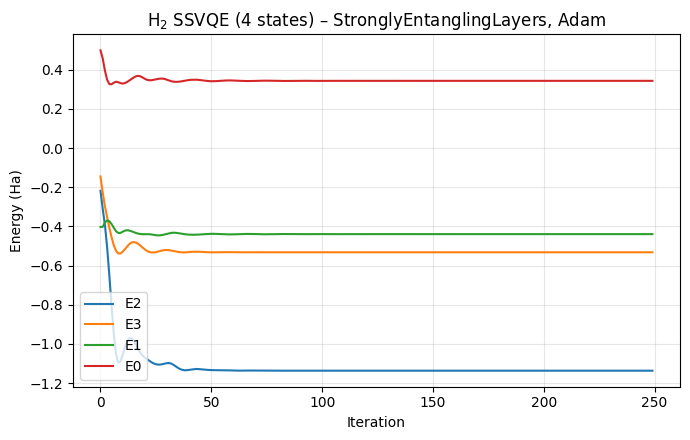

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/ssvqe_conv_StronglyEntanglingLayers_Adam.png


In [6]:
energies = noiseless_results["energies_per_state"]
finals = np.array([traj[-1] for traj in energies], dtype=float)
order = list(np.argsort(finals))

plot_multi_state_convergence(
    energies_per_state=energies,
    ssvqe_or_vqd="SSVQE",
    molecule=molecule,
    ansatz=ansatz_name,
    optimizer=optimizer_name,
    order=order,
    state_labels=[f"E{i}" for i in range(num_states)],
    show=True,
    save=True,
)

## 2) Noisy SSVQE using built-in depolarizing/amplitude probs

In [7]:
depolarizing_prob = 0.05
amplitude_damping_prob = 0.05

noisy_results = run_ssvqe(
    molecule=molecule,
    num_states=num_states,
    weights=weights,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    noise_model=None,
    plot=False,
    force=False,
)

_summarize_ssvqe(
    noisy_results,
    evals,
    label=f"Noisy SSVQE: dep={depolarizing_prob}, amp={amplitude_damping_prob}",
)

KeyboardInterrupt: 

In [ ]:
energies = noisy_results["energies_per_state"]
finals = np.array([traj[-1] for traj in energies], dtype=float)
order = list(np.argsort(finals))

plot_multi_state_convergence(
    energies_per_state=energies,
    ssvqe_or_vqd="SSVQE",
    molecule=molecule,
    ansatz=ansatz_name,
    optimizer=optimizer_name,
    order=order,
    state_labels=[f"E{i}" for i in range(num_states)],
    show=True,
    save=True,
)